# Probabilistic Programming - 1 
## Monte Carlo sampling

In this lesson we are going to use Monte Carlo sampling for regression & classification. We will use Turing.jl to specify a model and run a sampling procedure. While Probabilistic Programming requires some specialised knowledge in terms of probability theory and Bayesian statistics, implementing an inference procedure is straightforward once you have the right tools.

### Preliminaries

- Goal 
  - Learn to estimate regression parameters using Monte Carlo sampling.
- Materials        
  - Mandatory
    - These lecture notes.
    - [Intro to programming in Julia](https://youtu.be/8h8rQyEpiZA?t=233).
  - Optional
    - Tutorials using [Turing.jl](https://turing.ml/dev/tutorials/0-introduction/)
    - Cheatsheets: [how does Julia differ from Matlab / Python](https://docs.julialang.org/en/v1/manual/noteworthy-differences/index.html).

## Introduction to Turing.jl
[Turing.jl](https://turing.ml/dev/) is a Probabilistic Programming library written in Julia. Turing relies on MC sampling based procedures to perform inference. It is easy to learn but difficult to master, since optimizing the sampling procedure for a particular problem can require quite some expertise.

Things to keep in mind when using Turing:
1. Sampling based inference always runs. This means Turing can handle a wider class of problems than variational inference.
2. Sampling based inference is stochastic. Your results will vary between runs.
3. Sampling based inference is slow. 

Now, let's proceed with an example.

In [1]:
#TODO: finish workspace packaging
# # Package managing
# using Pkg
# Pkg.activate("workspace")
# Pkg.instantiate()

In [2]:
using Logging; disable_logging(LogLevel(0))
using StatsPlots
using Random
using Distributions
using Turing
using MCMCChains
include("../scripts/pp-1.jl");

### Data generation

We'll generate a simple regression problem setting. Given a data set $x = (x_1, \dots, x_N)$ of $N$ samples, we generate the set of observations $y = (y_1, \dots, y_N)$ via: 

$$ y = f(x) + \epsilon$$ 

where $f(x) = x*w_1 + w_2$ and $\epsilon \sim \mathcal{N}(0, \sigma)$. We summarize the slope coefficient and intercept into a single weight vector, $w = [w_1\ w_2]$. We will use the name "covariates" for $x$ and "responses" for $y$.

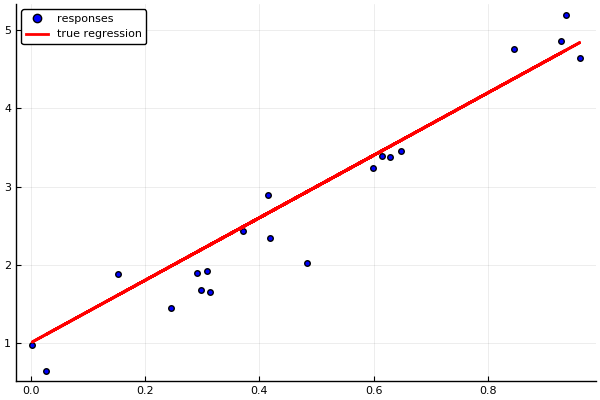

In [3]:
# Number of samples
N = 20

# Parameters
true_w = [4.0; 1.0]
true_σ = 1/2

function generate_data(true_w, true_σ; num_samples=10)
    "Generate data according to y = x⋅w + ϵ"
    
    # Covariates
    x = rand(Uniform(0,1), num_samples)
    
    # Linear function of covariates
    fx = x.* true_w[1] .+ true_w[2] 
    
    # Generate Gaussian noise
    ϵ = rand(Normal(0, true_σ), num_samples)
    
    # Responses consist of the linear mapping plus noise
    y = fx + ϵ
    
    # Return covariates and responses
    return y, x
end

# Generate data
responses, covariates = generate_data(true_w, true_σ, num_samples=N)

# True regression of the covariates
fx = covariates*true_w[1] .+ true_w[2]

# Visualize data
scatter(covariates, responses, color="blue", label="responses", legend=:topleft)
plot!(covariates, fx, color="red", label="true regression", linewidth=2)

### Model Specification

Turing has an intuitive means of specifying a model. It follows the math quite closely, and your final model will resemble a system of equations.

In [4]:
@model linear_regression(x, y, true_σ) = begin 
    
    # Extract number of samples
    num_samples = size(x, 1)
    
    # Weights prior parameters
    μ_w = [0.5; 0.]
    σ_w = 10*[1. 0.; 0. 1.]
    
    # Define a Gaussian prior distribution for the weights 
    w ~ MvNormal(μ_w, σ_w)

    # Loop over data points
    for i in 1:num_samples
        
        # Specify that responses are a Gaussian perturbation
        y[i] ~ Normal(x[i]*w[1] + w[2], true_σ) 
        
    end
end;

Now we are ready to infer the weights. For this problem setting, we will use the No U-Turn Sampler (NUTS). As stated in the introduction notebook, don't worry too much about the details of the sampler. But if you are feeling adventurous, feel free to try out the other ones or try out different sampler parameter settings. Can you get better results? What happens to the runtime?

In [5]:
# Hide the progress prompt while sampling.
Turing.turnprogress(false);

# Construct a Markov chain and draw samples
chain = Turing.sample(linear_regression(covariates, responses, true_σ), NUTS(500, 0.6), 1000);

The inference procedure has introduced a new object: the MCMCChain. It holds the samples as well as some diagnostic information to assess convergence of the sampler. Let's take a look.

In [6]:
describe(chain)

2-element Array{ChainDataFrame,1}

Summary Statistics
. Omitted printing of 1 columns
│ Row │ parameters │ mean     │ std      │ naive_se  │ mcse      │ ess     │
│     │ Symbol     │ Float64  │ Float64  │ Float64   │ Float64   │ Any     │
├─────┼────────────┼──────────┼──────────┼───────────┼───────────┼─────────┤
│ 1   │ w[1]       │ 4.45275  │ 0.417306 │ 0.0186625 │ 0.0623434 │ 98.8482 │
│ 2   │ w[2]       │ 0.614087 │ 0.224654 │ 0.0100468 │ 0.0374982 │ 87.7012 │

Quantiles

│ Row │ parameters │ 2.5%     │ 25.0%    │ 50.0%    │ 75.0%    │ 97.5%   │
│     │ Symbol     │ Float64  │ Float64  │ Float64  │ Float64  │ Float64 │
├─────┼────────────┼──────────┼──────────┼──────────┼──────────┼─────────┤
│ 1   │ w[1]       │ 3.69052  │ 4.17963  │ 4.44541  │ 4.71086  │ 5.39798 │
│ 2   │ w[2]       │ 0.175634 │ 0.480064 │ 0.613099 │ 0.749905 │ 1.03707 │


The above table summarizes properties of the Markov chain. A lot of the entries are not important at the moment, so we will focus on the posterior distribution over the weights $w_1$ and $w_2$. Did the sampler succesfully manage to recover the parameters of the data generating process? 

We can also plot the chain. That will give us a visual clue of whether it has converged and what the approximate posterior looks like.

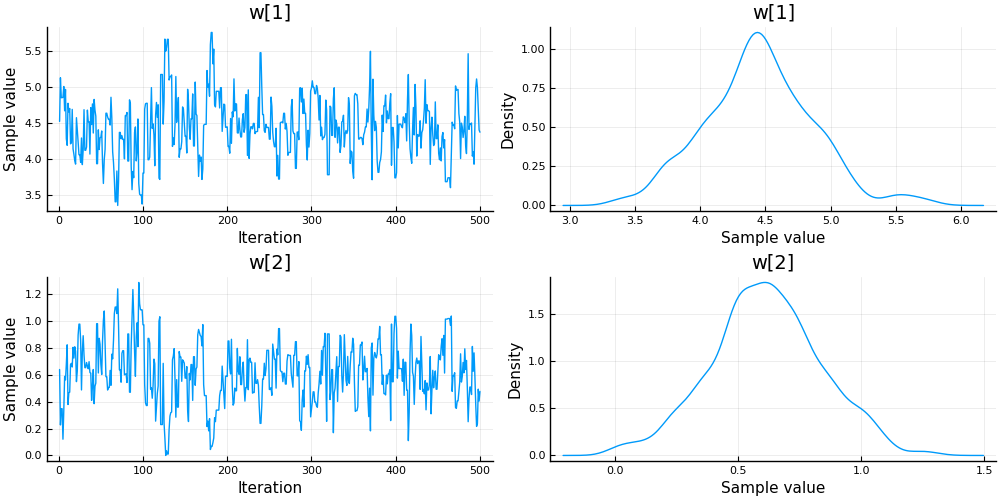

In [7]:
plot(chain)

We can also make predictions using the expected value of the weight posterior.

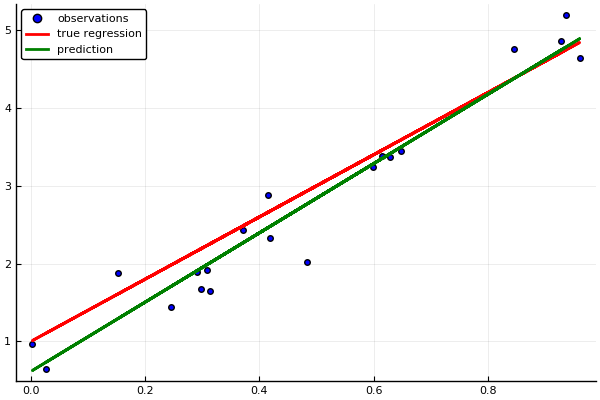

In [8]:
# Extract mean weights
w_hat = mean_chain(chain, :w)

# Make predictions
y_hat = covariates * w_hat[1] .+ w_hat[2]

# Visualize true data and observations
scatter(covariates, responses, color="blue", label="observations", legend=:topleft)
plot!(covariates, fx, color="red", label="true regression", linewidth=2)

# Overlay predictions
plot!(covariates, y_hat, color="green", label="prediction", linewidth=2)

Now it's your turn. Below are a few assignments to hone your skills with Probabilistic Programming in Turing.

### Optional assignment 1: classification
The code below generates a dataset of 0's and 1's. Your task is to turn the Turing model above into a binary classifier. The probabilistic model looks like this:

$$ \begin{align} w \sim&\ \mathcal{N}(\mathbf{\mu_w},\mathbf{\sigma_w})\\
y^\prime{} \sim&\ \mathcal{N}(f(x),\sigma_y) \\
p =&\ \sigma(y^\prime{}) \\
y \sim&\ \mathcal{B}er(p)) \end{align} $$

As you can see, it is pretty similar to the linear regression covered so far. The main difference is that $y$ is now a Bernoulli distribution since the data consists of 0's and 1's. We call $x$ "features" now and $y$ "labels". The Bernoulli distribution takes a single parameter $p$ in the range [0,1]. Hence we need to squash the output of the regression $y^\prime{}$ using a logistic function $\sigma$. To that end we have provided a function for you to use.

In [9]:
# Number of samples
N = 10

# Sigmoid function
σ(x) = 1/ (1 + exp(-x))

# Parameters for generating data
true_w = [1.0; 0.5]
true_σ = 1.

function generate_binary_data(true_w, true_σ; num_samples=10)
    
    # Generate data
    x = rand(Normal(0, true_σ), num_samples,)
    
    # Linear mapping of covariates 
    fx = [x ones(num_samples,)]*true_w
    
    # Observations
    y = round.(σ.(fx))
    
    return y, x
end

# Binary dataset
labels, features = generate_binary_data(true_w, true_σ, num_samples=N);

In [10]:
@model binary_classifier(x, y, n) = begin
    
    # Parameters for priors
    μ_w = # YOUR CODE HERE
    σ_w = # YOUR CODE HERE
    σ_y = # YOUR CODE HERE
    w ~ # YOUR CODE HERE

    y_prime = Vector(undef,n)
    for i in 1:n # Loop over data points
        
        y_prime[i] ~ #YOUR CODE HERE
        y[i] ~ # YOUR CODE HERE
        
    end
end

chain = Turing.sample(binary_classifier(features, labels, N), NUTS(500,0.65), 5000);
describe(chain)

LoadError: syntax: unexpected "end"

### Optional assignment 2: Markov chain convergence

[MCMCChains.jl](https://github.com/TuringLang/MCMCChains.jl) has a number of functions to help you examine your chain's convergence. Check the documentation and argue for why you believe your chain has converged (or not). Play around with the parameters of the sampler until you get a chain that keeps drifting. Why is this happening?

In [11]:
# YOUR CODE HERE

### Optional assignment 3: Regressing real data
Download the Titanic dataset from https://web.stanford.edu/class/archive/cs/cs109/cs109.1166/stuff/titanic.csv. It contains passenger information of the Titanic. Build a classifier that predicts whether a passenger survives or not, based on the available information. You will have to do your own data wrangling to get the data set into the right shape, as well as come up with your own model specification and parameterisation.

In [12]:
# YOUR CODE HERE